# Project

1. Central Idea
    - Idea: We analyze ~18,000 research papers related to Large Language Models and modern AI (LLMs, agentic AI, RAG, foundation models, transformers), downloaded from OpenAlex.
        Our goal is to reveal how ideas evolve in this field, and identify:
        - which topics dominate the field,
        - which papers are most influential,
        - which authors and institutions drive the research.
    - Why interesting? 
    LLMs are evolving extremely fast—every month there is a new architecture, agent framework, or RAG improvement. The public sees hype; we want to see the actual scientific movement.We want to know:
        - Are today's buzzwords (agents, reasoning, RAG) actually backed by science?
        - Who are the “idea hubs” (top-cited papers, institutions)?
        - Which topics are emerging vs. declining?
    - What datasets were explored? How did I download them? We are exploring a dataset of 20000 papers downloaded from OpenAlex. We used the query with parameters large language model|language model|pretrained language model|foundation model|transformer|LLM|agentic AI|AI agent|tool use|retrieval augmented generation|retrieval-augmented|model context protocol), later than 2000 and must have some references. 
2. Total Size of the Data. 17891 json files
    - Papers Citation Graph: 17891 nodes and 54295 edges
    - Co-autors graph: 65931 nodes, 285288 edges
    - Author Citation network: 55431 nodes, 2206140 edges
3. What is the network? - the oens rpesented above 
4. What is the text? The text is the actual text of the papers, and if that is absent we will use the abstract
5. How will text and networks be tied together? The text will be used to determine the most popular terms in the network, build communities and identify which authors defined popular technologies. 

## Papers Citation Graph

In [6]:
import os
import json
import networkx as nx

FOLDER = "papers_full"

G = nx.DiGraph()

def extract_id(url):
    if not url:
        return None
    return url.strip().split("/")[-1]

# Load all papers once into memory {paper_id: json_data}
paper_data = {}

print("Loading JSON files...")

for filename in os.listdir(FOLDER):
    if not filename.endswith(".json"):
        continue

    paper_id = filename.replace(".json", "")

    with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    paper_data[paper_id] = data

print(f"Loaded {len(paper_data)} papers")

print("Building graph...")

for paper_id, data in paper_data.items():

    # Convert authors from list -> single string
    authors = ", ".join([a.get("name") for a in data.get("authors", [])])

    G.add_node(
        paper_id,
        title=str(data.get("title") or ""),
        year=str(data.get("year") or ""),
        authors=authors,                      # <--- GEXF friendly
        abstract=str(data.get("abstract") or ""),  # keep abstract (short)
        # full_text removed (too big + not needed for graph format)
    )

    for ref_url in data.get("references", []):
        ref_id = extract_id(ref_url)
        if ref_id in paper_data:
            G.add_edge(paper_id, ref_id)


print("Graph completed.")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")


Loading JSON files...
Loaded 17891 papers
Building graph...
Graph completed.
Nodes: 17891
Edges: 54295


### Export the graph

In [7]:
nx.write_gexf(G, "papers_citation_graph.gexf")


In [8]:
# Example centrality measures
pagerank = nx.pagerank(G)
degree = dict(G.out_degree())

# Sorted most cited (high indegree)
most_cited = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 most cited papers (by indegree):")
for paper_id, indeg in most_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    print(f"{paper_id} ({indeg} citations): {title}")

Top 20 most cited papers (by indegree):
W3094502228 (897 citations): An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
W4221143046 (669 citations): Chain-of-Thought Prompting Elicits Reasoning in Large Language Models
W2979826702 (586 citations): Transformers: State-of-the-Art Natural Language Processing
W2911489562 (495 citations): BioBERT: a pre-trained biomedical language representation model for biomedical text mining
W4384071683 (450 citations): Large language models encode clinical knowledge
W2964110616 (393 citations): Transformer-XL: Attentive Language Models beyond a Fixed-Length Context
W2981852735 (342 citations): Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer
W3030163527 (342 citations): Language Models are Few-Shot Learners
W4319662928 (339 citations): Performance of ChatGPT on USMLE: Potential for AI-assisted medical education using large language models
W2970476646 (316 citations): Language Models as Knowledge B

### Degree Distribution

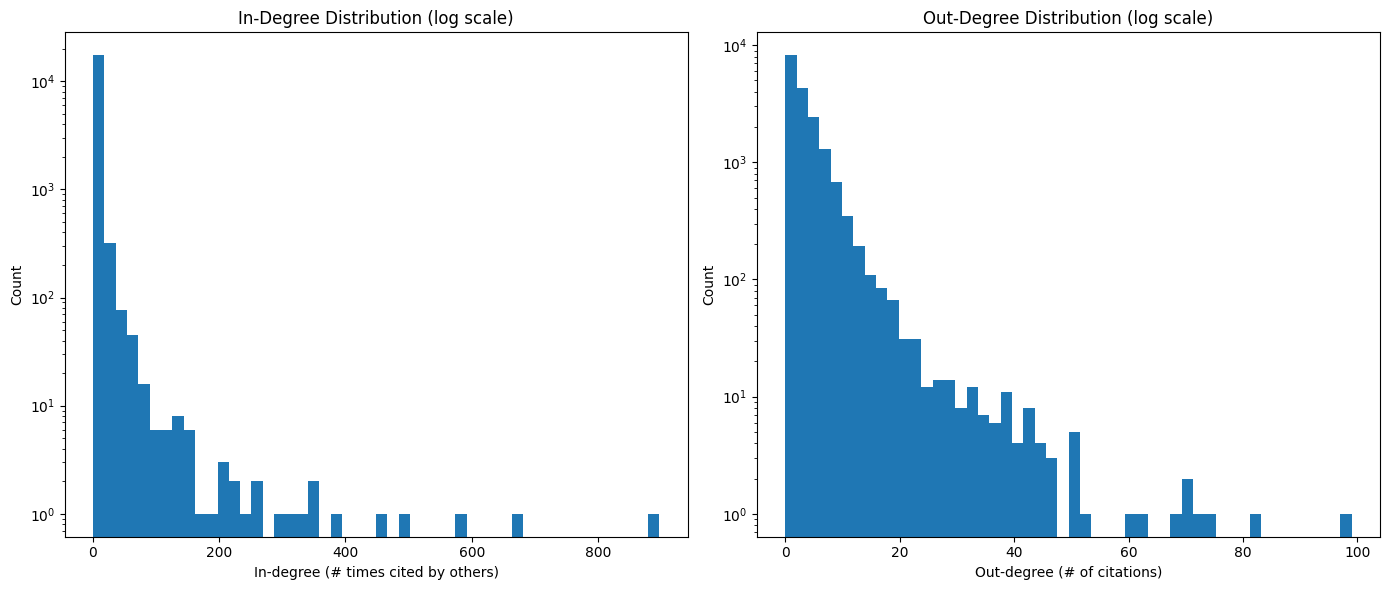

In [11]:
import matplotlib.pyplot as plt

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-degree (# times cited by others)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-degree (# of citations)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Co-authorship network

In [13]:
import networkx as nx
import itertools
import json
import os

G = nx.Graph()  # undirected co-authorship network

for file in os.listdir("papers_full"):
    if not file.endswith(".json"):
        continue

    with open(os.path.join("papers_full", file), encoding="utf-8") as f:
        data = json.load(f)

    # Extract only valid author IDs
    authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

    # Skip papers with fewer than 2 authors (no collaboration)
    if len(authors) < 2:
        continue

    # Add authors as nodes
    for author in authors:
        G.add_node(author)

    # Add undirected edges between co-authors
    for a1, a2 in itertools.combinations(authors, 2):
        G.add_edge(a1, a2)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 65931
Edges: 285288


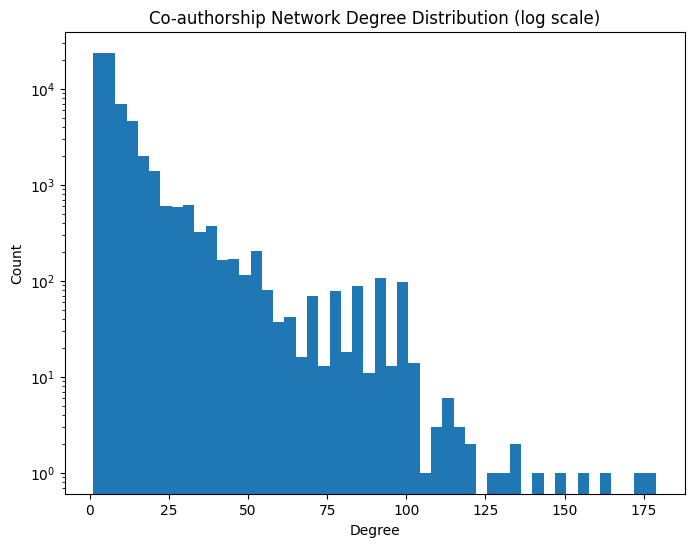

In [14]:
### Degree distribution of co-authors

import matplotlib.pyplot as plt

degrees = [d for _, d in G.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Co-authorship Network Degree Distribution (log scale)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()


### Author Citation Network

In [16]:
import networkx as nx
import os
import json

G = nx.DiGraph()

# Preload all paper data
papers = {
    fname[:-5]: json.load(open("papers_full/" + fname, encoding="utf-8"))
    for fname in os.listdir("papers_full")
    if fname.endswith(".json")
}

for paper_id, data in papers.items():

    # Extract only valid author IDs
    authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

    for ref_url in data.get("references", []):
        ref_id = ref_url.split("/")[-1]
        ref_paper = papers.get(ref_id)

        if not ref_paper:
            continue

        # Extract referenced paper's author IDs (filter out None)
        ref_authors = [a.get("id") for a in ref_paper.get("authors", []) if a.get("id")]

        # Create directed edges author → referenced_author
        for a in authors:
            for b in ref_authors:
                if a and b:  # prevent invalid edges
                    G.add_edge(a, b)

print("✅ Author citation network built")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")


✅ Author citation network built
Nodes: 55431
Edges: 2206140


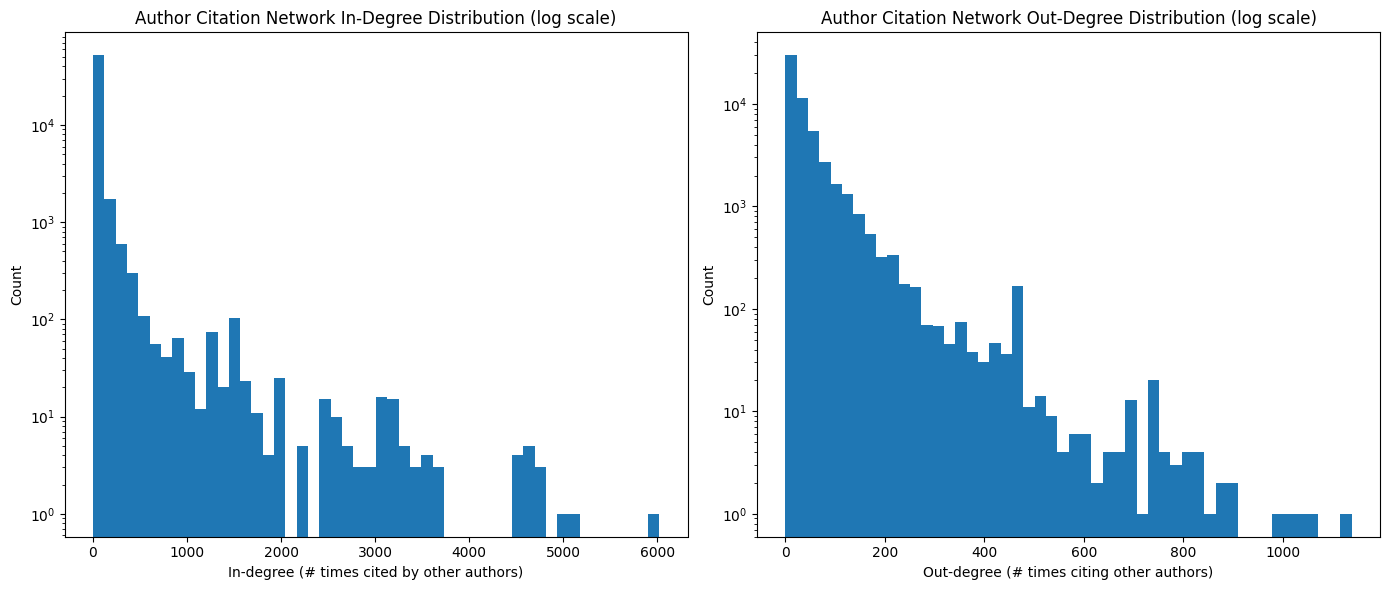

In [17]:
### Degree distribution of authors citing each other
import matplotlib.pyplot as plt

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Author Citation Network In-Degree Distribution (log scale)")
plt.xlabel("In-degree (# times cited by other authors)")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Author Citation Network Out-Degree Distribution (log scale)")
plt.xlabel("Out-degree (# times citing other authors)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

nx.write_gexf(G, "author_citation_network.gexf")